## Autoencoders

Author: Calvin Chan

### Introduction

In this notebook, we will go through using autoencoders to see if it can reconstruct our signals. Upon successful reconstruction, it means that the neural network is able to capture features of our data. Throughout this notebook, we will only consider the 100 Hz signals.

### Table of Contents
- [Data Import](#import)
- [Autoencoder](#encoder)
- [Model Evaluation](#evaluation)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import load_functions as f
import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

%autosave 300

Autosaving every 300 seconds


<a id='import'></a>
### Data Import

Let's import a sample of our data first using our function created in `functions.py`.

**Note**: Part of the following code is taken from `example_physionet.py` as part of the data set, which can be found [here](https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py).

In [3]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Test data size
sample_size = 5000

# Load sample - low sampling rate
X_sample, y_sample = f.load_sample_signal(sample_size, path, metadata)

X_sample.shape, y_sample.shape

((5000, 1000, 12), (5000,))

Let's first try a train test split without utilizing `strat_fold`, that is the column that the data source predefined for us how we should split our data for optimal results. A reminder, for our target column, we need to use `stratify` because we have unbalanced data. 

In [4]:
# Check for target column distribution
y_sample.value_counts()

NORM    2196
MI       941
CD       800
STTC     755
HYP      308
Name: diagnostic_superclass, dtype: int64

Let's plot 2 of each type of ECG superclass. We do this by slicing out only the first 2 signals in our sample data and only look at Lead I. 

In [5]:
# Let's only plot the first electrode by performing a 3D slice on our data
norm = X_sample[y_sample == 'NORM'][:2,:,0]
sttc = X_sample[y_sample == 'STTC'][:2,:,0]
mi = X_sample[y_sample == 'MI'][:2,:,0]
cd = X_sample[y_sample == 'CD'][:2,:,0]
hyp = X_sample[y_sample == 'HYP'][:2,:,0]

In [6]:
# Shape of our classes
norm.shape

(2, 1000)

Setting up the parameters, we plot each diagnostic below.

In [7]:
# Setting the appropriate parameters
sig_len = 1000
sampling_frequency = 100
superclasses = [norm, sttc, mi, cd, hyp]
names = ['NORM', 'STTC', 'MI', 'CD', 'HYP']

time = np.arange(0, sig_len) / sampling_frequency

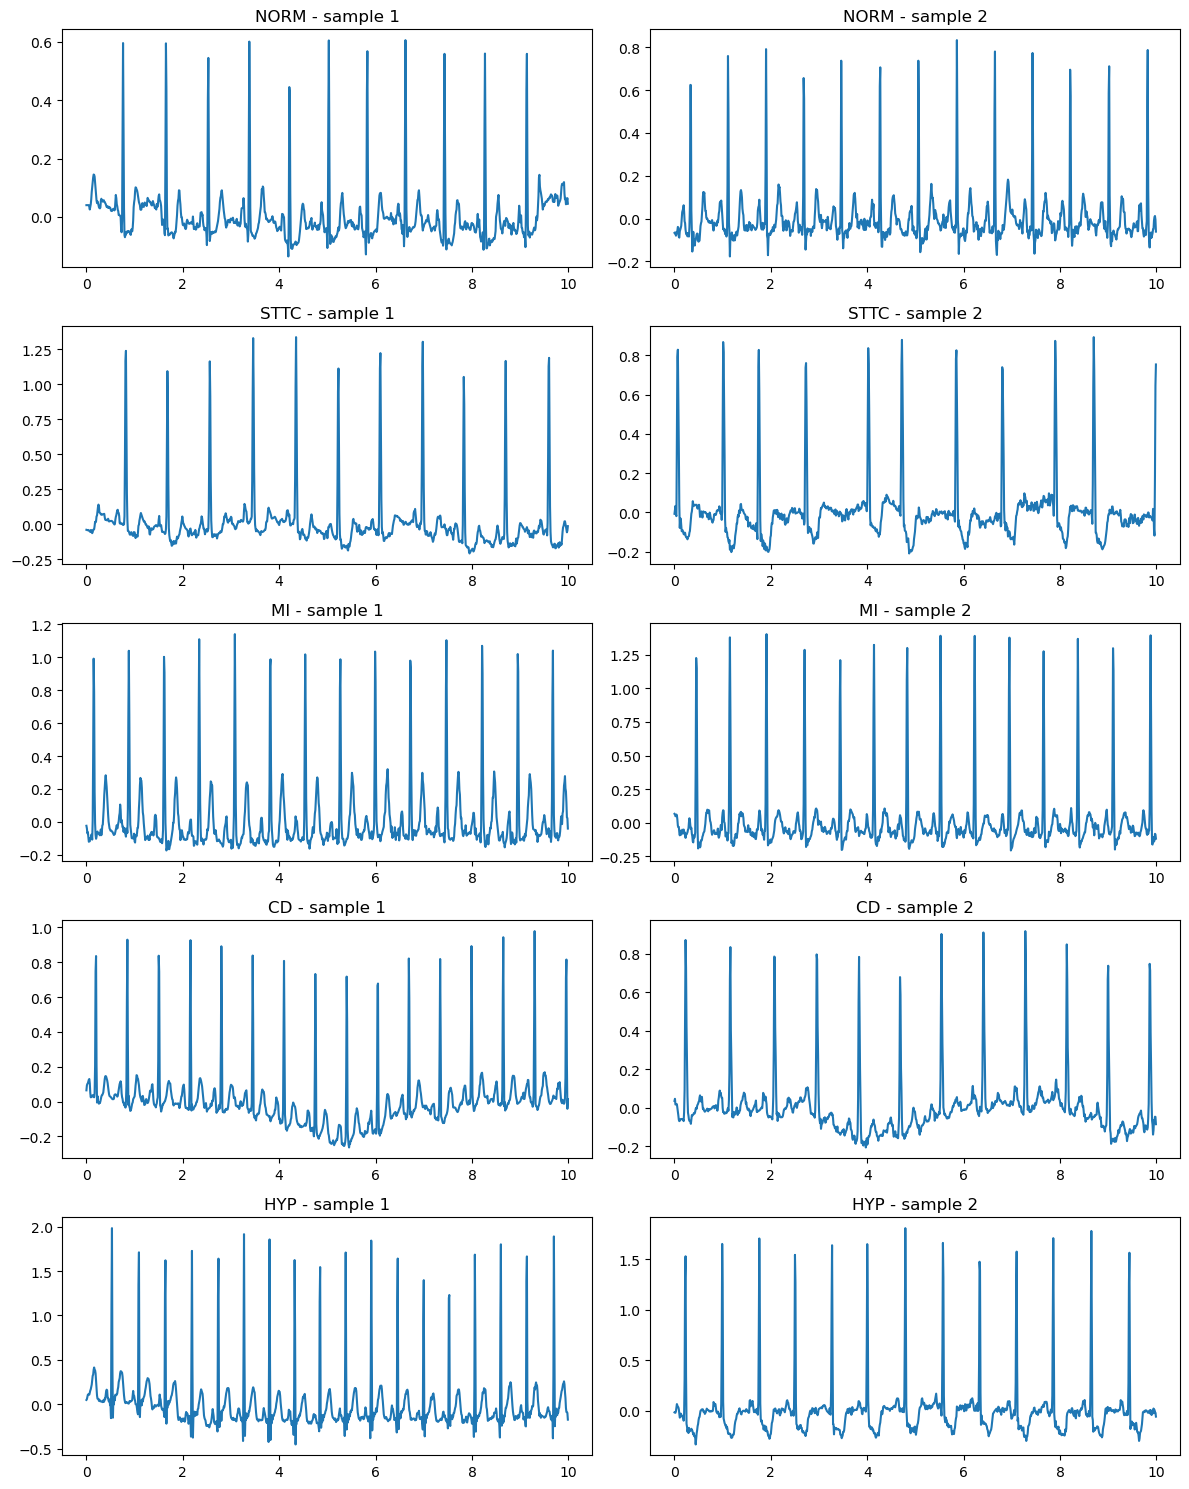

In [8]:
# Plotting the different classes
fig, ax = plt.subplots(figsize=(12,15), nrows=5, ncols=2)

for i in range(len(superclasses)):
    ax[i,0].plot(time, superclasses[i][0])
    ax[i,1].plot(time, superclasses[i][1])

    ax[i,0].set_title(f"{names[i]} - sample 1")
    ax[i,1].set_title(f"{names[i]} - sample 2")

fig.tight_layout()

### Full Data Import 

We will import our full data looking at **low sampling frequency**.

In [4]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [9]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [10]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

In [13]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal
signal_bl = c.baseline_removal(X, freq_start=0.1, freq_stop=1.5)
signal_pli = c.high_freq_removal(signal_bl, freq_start=40)

<a id='encoder'></a>
### Autoencoder

Now that we have seen our signals, we can use autoencoders. Essentially the goal of autoencoders is for the model to reconstruct our signal. If the model is able to do so, it means that it was able to learn the features associated with our data. 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import random as tf_random
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
# Label Encode y data

# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

print(label.classes_)

# Transform target column 
y = label.transform(y)

["['CD', 'MI']" "['CD', 'NORM']" "['CD', 'STTC']" "['CD']" "['HYP']"
 "['MI']" "['NORM']" "['STTC', 'HYP']" "['STTC', 'MI']" "['STTC']"]


Split data into training and validation set.

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000), (12541,))

In [24]:
X_val.shape, y_val.shape

((3136, 1000), (3136,))

Next we scale the data in the case that it is sensitive to distance. 

In [25]:
# Scale data
ss = StandardScaler()

# Fit and transform our training data using StandardScaler
X_train = ss.fit_transform(X_train)

# Transform our validation set as well
X_val = ss.transform(X_val)

Creating our fully-connected neural network, notice how we have a bottle neck. This is an inherit feature in autoencoders, by reducing the hidden layer to a really small amout of nodes, we force the model to learn only the importance features of our signals before it uses the features to reconstruct the signal. 

In [13]:
# Instantiate neural network
model = keras.Sequential()

# Add encoder part 
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dropout(rate=0.1))
model.add(layers.Dense(20, activation='relu'))

# Add decoder
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(1000, activation=None))

# Compiling our model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), 
    loss=keras.losses.SparseCategoricalCrossentropy,
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

# train our model
history = model.fit(X_train, X_train, 
                    validation_data=(X_val, X_val), 
                    epochs=20, 
                    verbose=2)

2024-04-02 00:49:58.263261: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
125/125 - 1s - loss: 0.9717 - mean_squared_error: 0.9717 - val_loss: 0.9572 - val_mean_squared_error: 0.9572 - 925ms/epoch - 7ms/step
Epoch 2/20
125/125 - 0s - loss: 0.9405 - mean_squared_error: 0.9405 - val_loss: 0.9502 - val_mean_squared_error: 0.9502 - 337ms/epoch - 3ms/step
Epoch 3/20
125/125 - 0s - loss: 0.9696 - mean_squared_error: 0.9696 - val_loss: 0.9491 - val_mean_squared_error: 0.9491 - 271ms/epoch - 2ms/step
Epoch 4/20
125/125 - 0s - loss: 0.9118 - mean_squared_error: 0.9118 - val_loss: 0.9441 - val_mean_squared_error: 0.9441 - 302ms/epoch - 2ms/step
Epoch 5/20
125/125 - 0s - loss: 0.9187 - mean_squared_error: 0.9187 - val_loss: 0.9449 - val_mean_squared_error: 0.9449 - 295ms/epoch - 2ms/step
Epoch 6/20
125/125 - 0s - loss: 0.8962 - mean_squared_error: 0.8962 - val_loss: 0.9418 - val_mean_squared_error: 0.9418 - 281ms/epoch - 2ms/step
Epoch 7/20
125/125 - 0s - loss: 0.8934 - mean_squared_error: 0.8934 - val_loss: 0.9375 - val_mean_squared_error: 0.9375 - 306ms/ep

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               200200    
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 50)                1050      
                                                                 
 dense_4 (Dense)             (None, 200)               10200     
                                                                 
 dense_5 (Dense)             (None, 1000)              2

<a id='evaluation'></a>
### Model Evaluation

Looking at our training and validation loss, we see that overall validation does not seem to drop as well as training. This means that there is overfitting happening. 

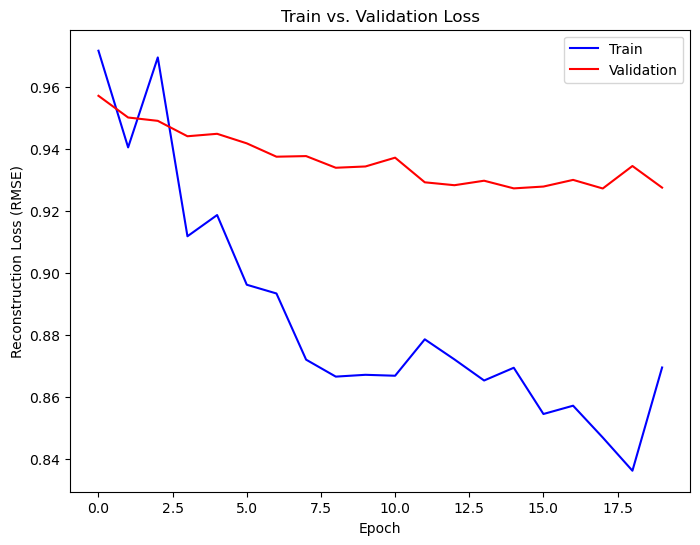

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_squared_error'], label="Train", c="b")
plt.plot(history.history['val_mean_squared_error'], label="Validation", c="r")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (RMSE)")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.show()

We can evaluate our model by asking it to reproduce our input signals. 

In [18]:
# Reconstruct signal 
X_train_reconstructed = model.predict(X_train.astype(np.float32))

In [19]:
X_train_reconstructed.shape

(4000, 1000)

In [20]:
X_train.shape

(4000, 1000)

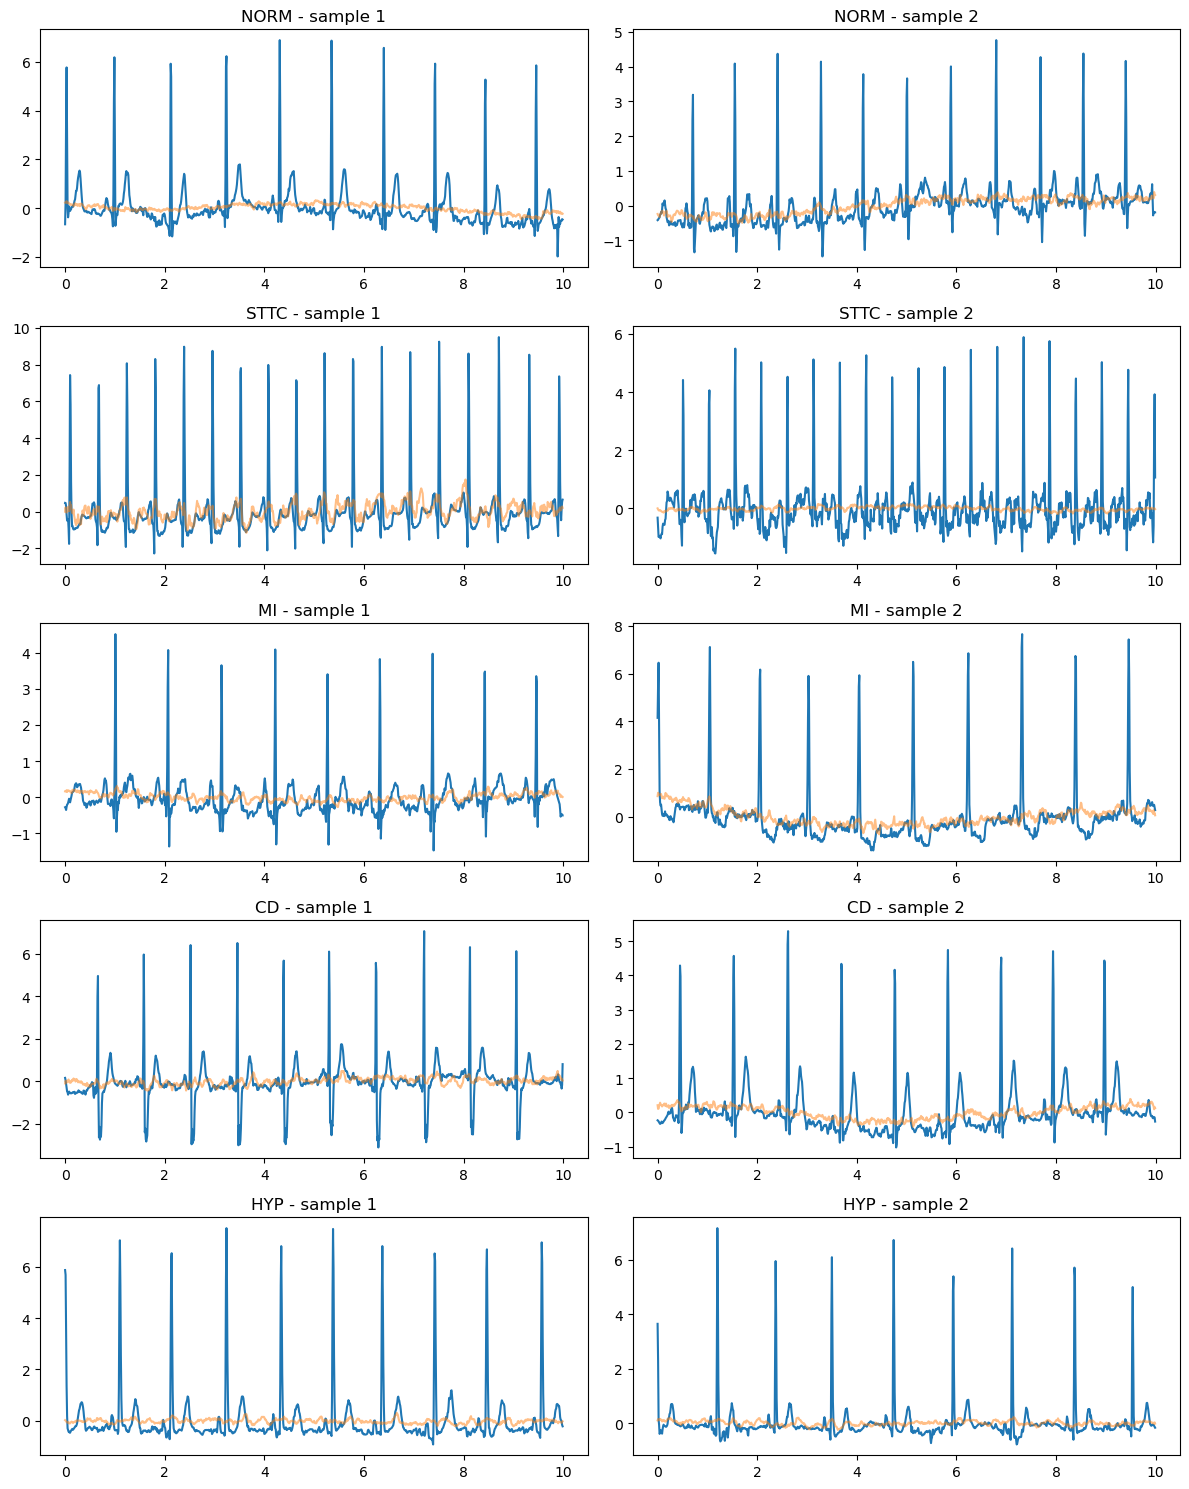

In [21]:
# Plot reconstructed signals
fig, ax = plt.subplots(figsize=(12,15), nrows=5, ncols=2)

for i in range(len(superclasses)):

    ax[i,0].plot(time, X_train[y_train == names[i]][0])
    ax[i,0].plot(time, X_train_reconstructed[y_train == names[i]][0], alpha=0.5)
    ax[i,1].plot(time, X_train[y_train == names[i]][1])
    ax[i,1].plot(time, X_train_reconstructed[y_train == names[i]][1], alpha=0.5)
    ax[i,0].set_title(f"{names[i]} - sample 1")
    ax[i,1].set_title(f"{names[i]} - sample 2")

fig.tight_layout()

From the graphs above, we see that the model does not capture important features in our signal. As such, it is unable to predict accurately our input signals. We can evaluate our model by looking at the errors in the reconstructed signal. 

In [22]:
# What is the biggest difference between input and output over the 1000 time-steps
reconstruction_error = abs(X_train - X_train_reconstructed).max(axis=1)

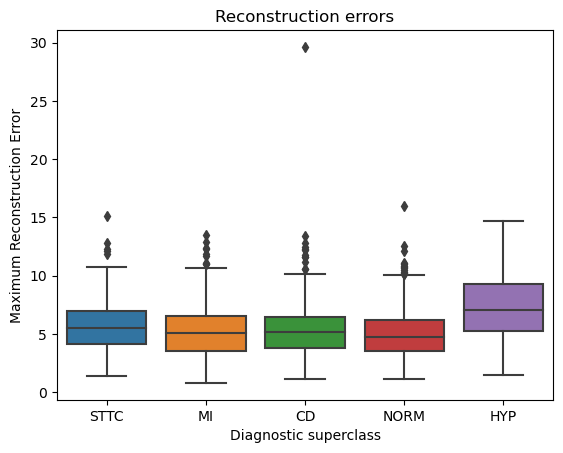

In [23]:
plt.figure()
sns.boxplot(y=reconstruction_error, x=y_train)
plt.title("Reconstruction errors")
plt.xlabel("Diagnostic superclass")
plt.ylabel("Maximum Reconstruction Error")
# plt.ylim(0, 0.2)
plt.show()

In [24]:
# What is the biggest difference between input and output over the 1000 time-steps
reconstruction_error = abs(X_train - X_train_reconstructed).mean(axis=1)

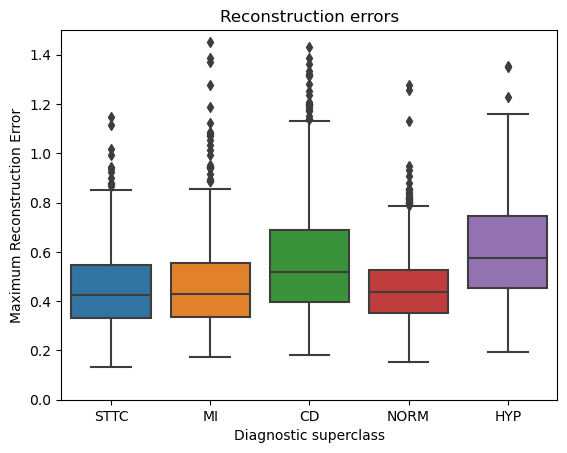

In [28]:
plt.figure()
sns.boxplot(y=reconstruction_error, x=y_train)
plt.title("Reconstruction errors")
plt.xlabel("Diagnostic superclass")
plt.ylabel("Maximum Reconstruction Error")
plt.ylim(0, 1.5)
plt.show()

From both boxplots, we see that it is difficult to distinguish between normal ECGs and the others resulting in poor reconstruction of the signal. 

### Next steps
- talk about the different approachs we looked at above for reconstruction_error and what we are seeing
- can try autoencoder again using lower frequency data set
- can also feed the low frequency data into a simple neural network classifier where the output layer is the 5 classes we have
- try RNNs
- try Logistic regression with histogram
- statistics
    - use hypothesis testing (one-tail test) to see whether there is a significance between normal ecg signals versus any of the other signals
        - could potentially lead to why I need to use Fourier Transforms to clean signals